# Step 1: Baseline Correction
Notebook Code: [![License: MIT](https://img.shields.io/badge/License-GPLv3-blue.svg)](https://www.gnu.org/licenses/gpl-3.0) Notebook Prose: [![License: CC BY 4.0](https://img.shields.io/badge/License-CC_BY_4.0-lightgrey.svg)](https://creativecommons.org/licenses/by/4.0/)


---

## What's in a baseline?

In liquid chromatographic analysis, compounds are carried through an absorptive substrate 
(termed a stationary phase) by a solvent (termed the mobile phase). In an ideal world, the column is saturated with the mobile phase and is held at a stable temperature and pressure. This sets baseline signal that can be subtracted from  
the signal detected over the course of the chromatographic separation, allowing 
for quantitation.

However, we don't live in a perfect world. Often, variations in the column temperature or ineffective equilibration of the column with the solvent, resulting 
in a drifting baseline. For complex samples, such as whole-cell metabolomic extracts,
a drifting baseline may result from the sheer number of compounds present in the sample at low abundance that convolve to a "bumpy" baseline. 

For quantitative analysis, we would like to correct for a drifting baseline, so we 
can more effectively tease out what signal is due to our compound of interest and 
what is due to nuisance. Take for example the following chromatogram with a known
"true" drifting baseline.

Text(0, 0.5, 'signal')

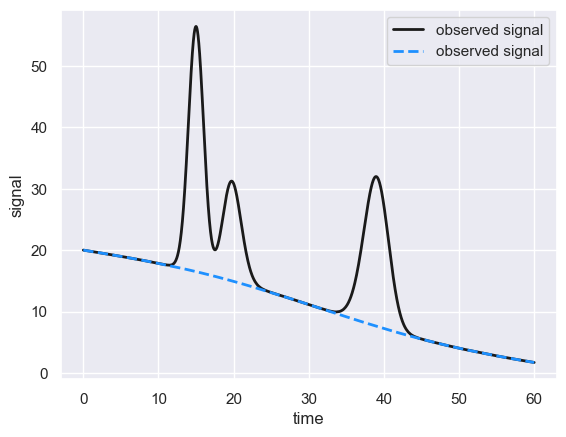

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Load a dataset with a known drifting baseline
df = pd.read_csv('data/sample_baseline.csv')

# Plot the convolved signal and the known baseline
plt.plot(df['time'], df['signal'], '-', color='k', label='observed signal', lw=2)
plt.plot(df['time'], df['true_background'], '--', color='dodgerblue',
         label='known baseline', lw=2)
plt.legend()
plt.xlabel('time')
plt.ylabel('signal')

This chromatogram was simulated as a mixture of three peaks with a known (large) 
drifting baseline (dashed blue line). But what if we don't know what the baseline is?

## Subtraction using the SNIP algorithm
In reality, we don't know this baseline, so we have to use clever filtering
tricks to *infer* what this baseline signal may be and subtract it from our
observed signal. There are many ways one can do this, ranging from [fitting of polynomial functions](https://www.sciencedirect.com/science/article/pii/S0169743905001589?via%3Dihub) to [machine learning models](https://pubs.rsc.org/en/content/articlelanding/2022/an/d2an00868h) and beyond. In `hplc-py`, we employ 
a method known as [**Statistical Non-linear Iterative Peak (SNIP) clipping**](https://www.sciencedirect.com/science/article/pii/0168583X88900638). his is 
implemented in the `hplc-py` package as method `correct_baseline` to the `Chromatogram` class. The SNIP algorithm works as follows.

### Log-transformation of the signal
First, the dynamic range of the signal $S$ is reduced through the application of an [LLS operator](https://cds.cern.ch/record/264009/files/P00023745.pdf). This prevents enormous peaks 
from dominating the filtering, leading to the erasure of smaller (yet still important) peaks. Mathematically, the compression $S \rightarrow S_{LLS}'$ is achieved by computing
$$
S_{LLS} =  \ln\left[\ln\left(\sqrt{S + 1} + 1 \right) + 1\right] \tag{1},
$$
where the application of the square-root operator selectively enhances small peaks while the log operator compresses the signal across orders of magnitude. Applying 
this operator to signal in our simulated chromatogram yields the following

Text(0, 0.5, 'signal')

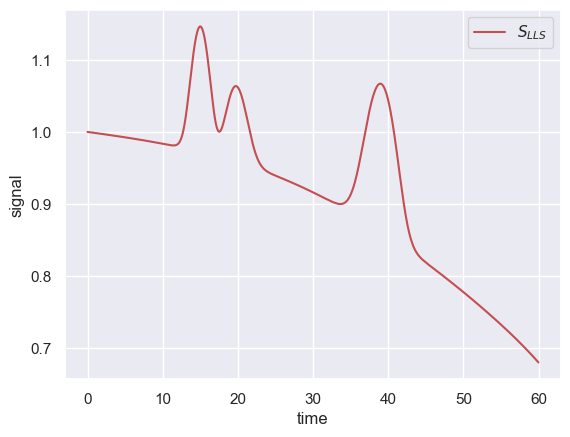

In [2]:
# Apply the LLS operator to the signal and visualize
import numpy as np
S = df['signal'].values
S_LLS = np.log(np.log(np.sqrt(S + 1) + 1) + 1) 
plt.plot(df['time'], S_LLS, '-', color='r', label="$S_{LLS}$")
plt.legend()
plt.xlabel('time')
plt.ylabel('signal')

Note that the y-axis has been compressed to a small range and that the first peak 
is now comparable in size to the other two peaks.

### Iterative Minimum Filtering

With a compressed signal, we can now apply a minimum filter over a given window 
of time $W$ over several iterations $M$. For each time point $t$ in the compressed signal, the filtered value $S'_{LLS}$ for iteration $m$ is computed as 
$$
S'_{LLS_m}(t) = \min\left[S_{LLS_{m-1}}(t), \frac{S_{LLS_{m-1}}(t-m) + S_{LLS_{m-1}}(t + m)}{2}\right] \tag{2}
$$
Note that the average value of the signal at time $t$ is compared to the average 
of the window boundaries, with the window increasing in size from one iteration 
to the next. To see this in action, we can plot the filtering result over the first 200 iterations of this 
procedure applied to the above compressed signal. 

Text(0, 0.5, 'signal')

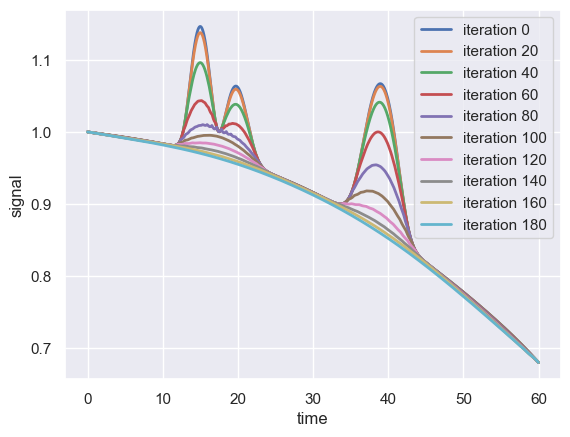

In [3]:
# Define a function to compute the minimum filter
def min_filt(S_LLS, m):
    """Applies the SNIP minimum filter defined in Eq. 2"""
    S_LLS_filt = np.copy(S_LLS)
    for i in range(m, len(S_LLS) - m): 
        S_LLS_filt[i] = min(S_LLS[i], (S_LLS[i-m] + S_LLS[i + m])/2)
    return S_LLS_filt

# Apply the filter for the first 100 iterations and plot
S_LLS_filt = np.copy(S_LLS)
for m in range(200):
    S_LLS_filt = min_filt(S_LLS_filt, m)
    # Plot every ten iterations
    if (m % 20) == 0:
        plt.plot(df['time'], S_LLS_filt, '-', label=f'iteration {m}', lw=2)

plt.legend()
plt.xlabel('time')
plt.ylabel('signal')

As the number of iterations increases in the above example, the actual peak signals 
become smaller and smaller, eventually approaching the baseline. 

### Inverse Transformation and Subtraction
Once the signal has been filtered across $M$ iterations, the filtered signal $S'_{LLS}$ can 
be passed through the inverse LLS operator to expand the dynamic range back to the scale of the observed data. This inverse operator, converting $S'_{LLS} \rightarrow S'$ is defined as
$$
S' = \left(\exp\left[\exp\left(S'_{LLS}\right)-1\right] - 1\right)^2 - 1. \tag{3}
$$

Performing the subtraction $S - S'$ effectively removes the baseline signal leaving 
only the "true" signal
 

Text(0, 0.5, 'signal')

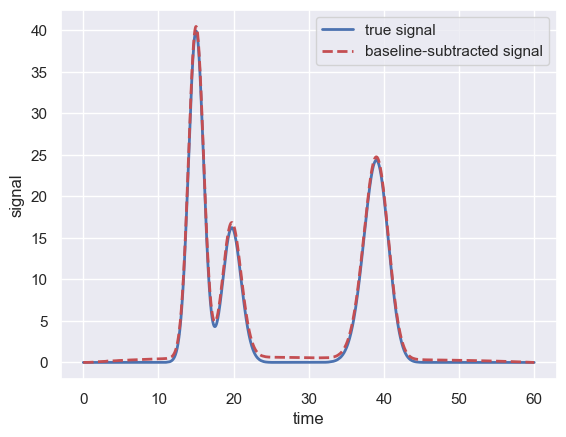

In [4]:
# Compute the inverse transform
S_prime = (np.exp(np.exp(S_LLS_filt) - 1) - 1)**2 - 1

# Perform the subtraction and plot the reconstructed signal over the known signal
S_subtracted = S - S_prime
plt.plot(df['time'], df['true_signal'], '-', lw=2, label='true signal')
plt.plot(df['time'], S_subtracted, '--', lw=2, color='r', label='baseline-subtracted signal')
plt.legend()
plt.xlabel('time')
plt.ylabel('signal')

With 200 iterations of the filtering, the baseline-subtracted signal is almost exactly overlapping the known signal, demonstrating the power of the SNIP algorithm.

## How many iterations?

The above is dependent on how many iterations are run. As described by Morhác and Matousek (2008), a good rule of thumb for choosing the number of iterations $M$ is

$$
M = \frac{W - 1}{2} \tag{4},
$$

where $W$ is the typical width (in number of time points) of the preserved
peaks. Choosing $W$ is dependent on your particular signal. In HPLC chromatograms,
the observed peaks are typically on the order of a minute or two wide. In
general, it’s advisable to be generous with the approximate peak widths as an
underestimation can result in subtracting actual signal.

## Implementation in `hplc-py`
The above SNIP background subtraction algorithm is included as a method
`correct_baseline` of a Chromatogram object. The above steps can be called in a
few lines of code as in the following:

Performing baseline correction: 100%|██████████| 124/124 [00:00<00:00, 487.52it/s]


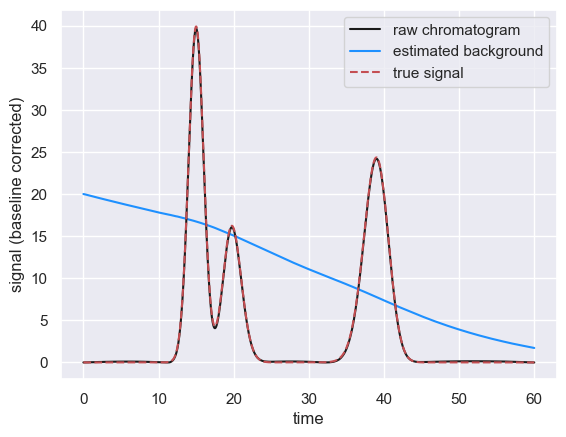

In [5]:
from hplc.quant import Chromatogram

# Load the dataframe as a chromatogram object
chrom = Chromatogram(df)

# Subtract the background given a peak width of ≈ 2 min
chrom.correct_baseline(window=2)

# Show the chromatogram
fig, ax = chrom.show()

# Plot the true signal
ax.plot(df['time'], df['true_signal'], 'r--', label='true signal')
ax.legend()

---

<small> © Griffin Chure, 2023. This notebook and the code within are released under a 
[Creative-Commons CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/) and 
[GPLv3](https://www.gnu.org/licenses/gpl-3.0) license, respectively.</small>
